## Course Example Project: Essay Writer 

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

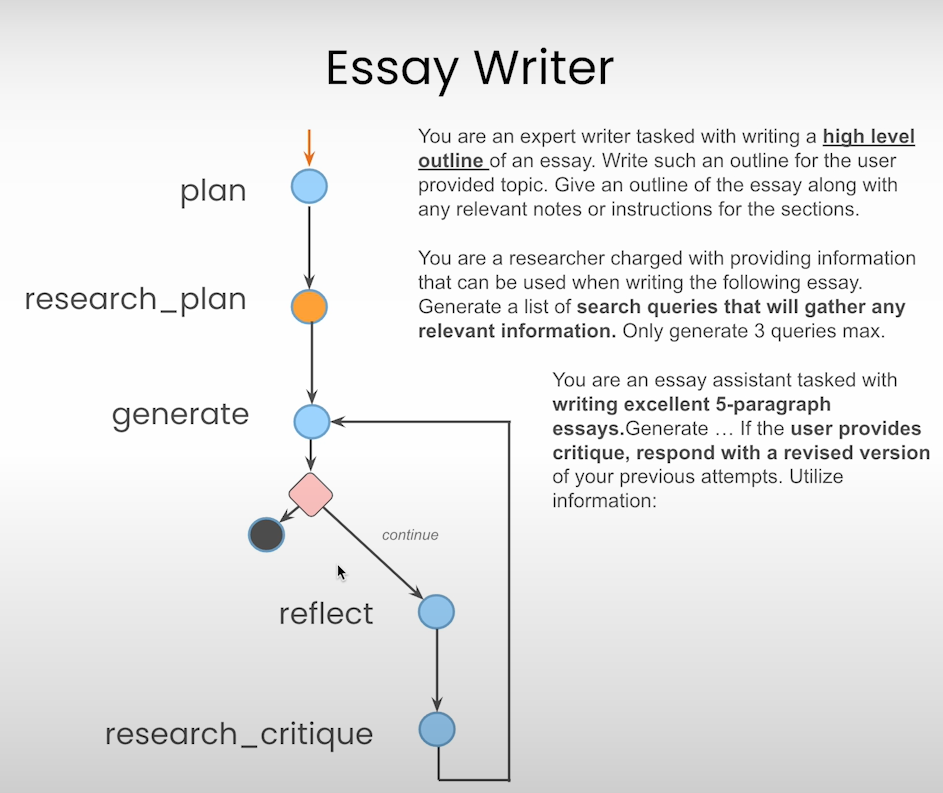

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

# memory = SqliteSaver.from_conn_string(":memory:")


from contextlib import ExitStack

stack = ExitStack()
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))
#first, we create the memmory saver of the graph

## 1. Define the memmory saver, and the ``Agent State`` of the graph

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int #we store here how many times did the graph loop through documents
    max_revisions: int 
    
    
#we store all the different state keys we want to keep track on

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

## 2. Defining the prompts

This will generate a plan for the essay

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

This one will write the essay given all the content that was researched

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

This one will control how we're critiquing the draft of the essay (e.g like a teacher, `so this will be a agent chain looping back until some criteria is met, and the essay quality is good`)

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

Given a plan, this one will generate the search queries and we'll pass them to the search engine (e.g `tavily`)

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


After we made the critique before, we'll made some queries to pass it to tavily.

It will basically redefine the new set of actions the graph will take to improve the essay, ``based on the previous critique``

In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


To ensure that we get a list of queries for tavily from the llm, we need to cast them using `pydantic` models, **so we can get the desired output from the llm**

## 3. Defining some desired output objects from the llm

In [10]:
from langchain_core.pydantic_v1 import BaseModel
# from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str] #

c:\Users\pablo\Desktop\P - Proyectos en Curso\agentic-portfolio-qa-interface\agents_env\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
#we'll import the TAVILY search CLIENT instead of the pre-defined tool
#because we'll use it in a slightly unconventional way

from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

Note:

```python
result = tavily.search("Which was the name of the Spanish king by 18th century?",
                       include_answer=True)

# print the answer
result["answer"]

>>> 'Charles III was the Spanish king during the 18th century, reigning from 1759 to 1788.'

```

In [12]:
# result = tavily.search("Which was the name of the Spanish king by 18th century?",
#                        include_answer=True)

# # print the answer
# result["answer"]

## 4. Creating the agent nodes

This node will take the current state of the agent (`AgentState`)

And it will create a list of ``messages:``

- One of them is gonna be the planning prompt (**SYSTEM MESSAGE** for the llm)

- The other one will be a **HUMAN_MESSAGE** type prompt which we are going to pass in to the model (it will be the task/topic we want to get a essay about)


In [13]:
def plan_node(state: AgentState):
    #the node which does the planning (outline)
    
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    #call the ChatOpenAI llm

    return {"plan": response.content}
#this will set the plan key to be this response (generated plan)

In [14]:
# model.invoke("YMCA, YMCA, young man, young man!")

Here, same as before, it will take the current `AgentState`

And here, it will run the llm with:

- The corresponding System Message for this task

- And a HumanMessage prompt input with the desired plan for the essay

Then, the LLM, will generate a list of `tavily search queries` to be called later. 

**We're ensuring it retrieves this desired list object, by using `model.with_structured_output(Queries)` when running the llm**

In [15]:
def research_plan_node(state: AgentState):
    #this agent will take the research plan
    #will generate some queries for the web
    #and will run and store them 
    
    
    queries = model.with_structured_output(Queries).invoke([
        #the response of this llm call will match the Queries Pydantic object
        #(list of queries)
        
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    
    # content = state['content'] or []
    if "content" not in state.keys():
        content = []
        
    else:
        content = state['content'] or []
    #we check in the state for previosly stored documents
    
    for q in queries.queries:
        
        #then here we run each query using tavily
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
        #we add to the original content list, all the new content from different search queries
            
    return {"content": content}

In [16]:
# model.with_structured_output(Queries).invoke("make me a list from 1 to 10")

This node will write the first draft

- We give it a ``SystemMessage`` first, with the `concatenated` f-string variable of all the retrieved documents

- And then we give a `HumanMessage` prompt input of the task i want to accomplish, and the generated task we got before

In [17]:
def generation_node(state: AgentState):
        
    content = "\n\n".join(state['content'] or [])
    
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        #we add the system message, and the humanmessage
        
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
            #we .format() the prompt with the f-string variable
            #corresponding to all the retrieved internet content for the essay
        ),
        user_message
        ]
    
    
    response = model.invoke(messages)
    #we run the model -> we get a first version of a essay
    
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
        #we'll update this state field, meaning that we 'revised' for first time the essay
    }


This, as you renember, is the node where the agent does a critique and recommendations to improve the current essay draft

In [18]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        #the system message instruction
        
        
        HumanMessage(content=state['draft'])
        #and the humanmessage input prompt of the current essay content
    ]
    
    response = model.invoke(messages)
    
    #then we get this new updated state field of the generated critique
    return {"critique": response.content}

Here, the agent takes the critique/reccomendations about the current essay draft, and **it will generate from that a new list of queries to search for new/better internet info**

In [19]:
def research_critique_node(state: AgentState):
    #we'll be casting again the llm output to match the pydantic object of a query list
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    
    for q in queries.queries:
        #we run again the generated queries, and we retrieve the content
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
            
    #then we append this new content
    return {"content": content}

Finally, we'll create this `conditional node`

It will decide whether the agent should continue looping back and improving the essay or not

In [20]:
#this will be running after the generation node
#after this first essay draft, it will take the decission

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## 5. Building the graph

In [21]:
builder = StateGraph(AgentState)

In [22]:
#putting together all the nodes

builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

### Setting the entrypoint of the graph

We'll make the entrypoint to be the `planner node` where it takes the input topic of the essay we want

And from there, it starts to run 

In [23]:
builder.set_entry_point("planner")

In [24]:

builder.add_conditional_edges(
    "generate", 
    should_continue, 
    #if the should_continue() function returns end
    #we'll end, if it returns "reflect" from the function,
    # we'll call the 'reflect' node
    {END: END, "reflect": "reflect"}
)

### Adding the basic edges (connections between nodes(actions))

In [25]:
builder.add_edge("planner", "research_plan")
#after planning, we're going to go through the research_plan node

builder.add_edge("research_plan", "generate")
#after making a research plan (node), we'll run the generate node

#and so on with these edges
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")
#and after all the new retrieved data we got from the research_critique node
#we'll generate again a new draft of essay

#until the should_continue() function returns END, so the graph stops

### Compiling the graph

In [ ]:
graph = builder.compile(checkpointer=memory)
                        # interrupt_after=["generate"],
                        # interrupt_before=)

In [27]:
from IPython.display import Image
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Image(graph.get_graph().draw_png())

In [28]:
# !pip install pygraphviz

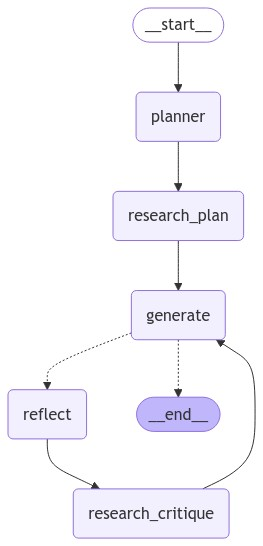

In [29]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## 6. Running the graph

In [30]:
# for i in graph.get_state_history(thread):
    
#     print(i)

We'll use `thread=1` for persistence details in order to let the single-llm we're using here renember all the previous context

In [31]:
thread = {"configurable": {"thread_id": "2"}}

for s in graph.stream({
    'task': "the plato philosophy", #"what is the difference between langchain and langsmith"
    "max_revisions": 2,
    "revision_number": 1
}, thread):
    print(s)


{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Plato\'s life and background\n    B. Explanation of the significance of Plato\'s philosophy\n\nII. Plato\'s Theory of Forms\n    A. Definition of Forms\n    B. The Allegory of the Cave\n    C. Criticisms and interpretations of the Theory of Forms\n\nIII. Plato\'s Epistemology\n    A. The role of reason and knowledge in Plato\'s philosophy\n    B. The theory of recollection\n    C. The divided line and the allegory of the sun\n\nIV. Plato\'s Political Philosophy\n    A. The ideal state in "The Republic"\n    B. The philosopher-king\n    C. Criticisms and modern interpretations of Plato\'s political ideas\n\nV. Legacy of Plato\'s Philosophy\n    A. Influence on Western philosophy\n    B. Contemporary relevance of Plato\'s ideas\n    C. Criticisms and challenges to Plato\'s philosophy\n\nVI. Conclusion\n    A. Recap of key points discussed\n    B. Reflection on the enduring impact of Plato\'s philosophy\n    C. Suggestions fo

We see how it stopped after ``revisions=2``, meaning that it stopped after the second draft.

(Notice how the critique node helped the llm to better redefine the essay )

__________________

# RESOURCES:

https://python.langchain.com/docs/introduction/

https://github.com/langchain-ai/langchain

https://github.com/langchain-ai/langgraph


high level LANGCHAIN entrypoints and templates from community:

https://smith.langchain.com/hub

**We can see different agent structures (e.g multi-agent one) over here:**


https://github.com/langchain-ai/langgraph/tree/main/examples

and 
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb

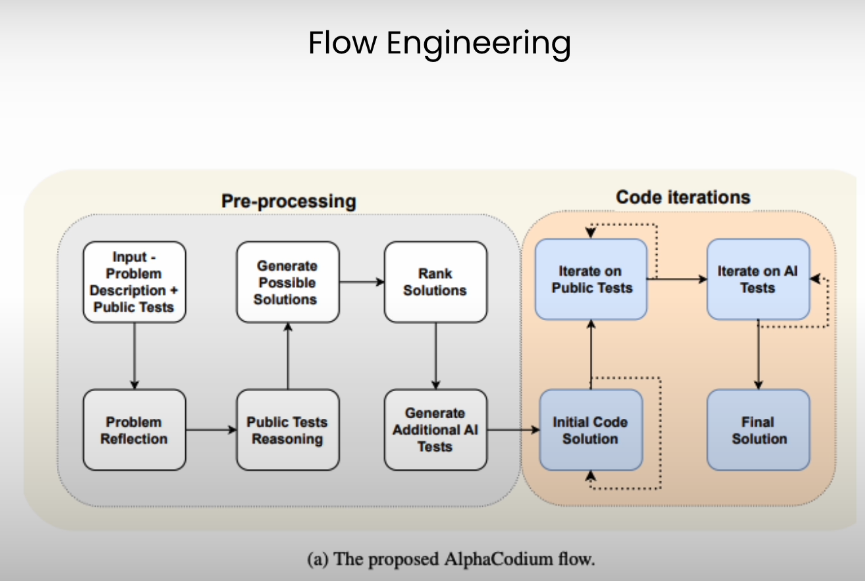